# auto_annot_Smillie2019_with_Haber2017_dblabel_l4

In [1]:
import besca as bc
import pandas as pd
import pkg_resources
import os

### Specify folders where .h5ad files are found and their names. 

The datasets that are already annotated and should be used for training. If you only use one dataset please use list of one.

In [2]:
adata_trains = [bc.datasets.Haber2017_processed()]

The dataset of interest that should be annotated.

In [3]:
adata_pred = bc.datasets.Smillie2019_processed()
adata_orig = bc.datasets.Smillie2019_processed()

Define level of dblabel reference annotation

In [4]:
level = 4

Give your analysis a name.

In [5]:
analysis_name = 'auto_annot_Smillie2019_with_Haber2017_dblabel_l' + str(level) 

### Now specify parameters

Specify column name of celltype annotation you want to train on.

In [6]:
celltype_train ='dblabel_l' + str(level)
celltype_test = 'dblabel_l' + str(level)

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [7]:
method = 'logistic_regression_elastic' # 'logistic_regression'

Specify merge method if using multiple training datasets. Needs to be either scanorama or naive.

In [8]:
merge = 'scanorama'

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [9]:
use_raw = False

You can choose to only consider a subset of genes from a signature set.

In [10]:
genes_to_use = 'all'

### Translate cell type annoation to lower dblabel level

In [11]:
new_cnames = bc.tl.sig.obtain_new_label(
    nomenclature_file=pkg_resources.resource_filename('besca', 'datasets/nomenclature/CellTypes_v1.tsv'), 
    cnames=list(adata_trains[0].obs['dblabel'].cat.categories), 
    reference_label='dblabel', 
    new_label='dblabel', 
    new_level=level)

new_cnames

new_label
goblet cell                                            goblet cell
proliferating epithelial fate stem cell  epithelial fate stem cell
enterocyte                                              enterocyte
epithelial fate stem cell                epithelial fate stem cell
immature goblet cell                          immature goblet cell
brush cell                                              brush cell
proliferating transit amplifying cell      transit amplifying cell
paneth cell                                            paneth cell
transit amplifying cell                    transit amplifying cell
proliferating enterocyte progenitor          enterocyte progenitor
immature enterocyte                                     enterocyte
enteroendocrine cell                          enteroendocrine cell
enterocyte progenitor                        enterocyte progenitor

In [12]:
adata_trains[0].obs['dblabel_l' + str(level)] = bc.tl.sig.add_anno(adata_trains[0], new_cnames, 'new_label', 'dblabel')

In [13]:
new_cnames = bc.tl.sig.obtain_new_label(
    nomenclature_file=pkg_resources.resource_filename('besca', 'datasets/nomenclature/CellTypes_v1.tsv'), 
    cnames=list(adata_pred.obs['dblabel'].cat.categories), 
    reference_label='dblabel', 
    new_label='dblabel', 
    new_level=level)

new_cnames

new_label
CD1c-positive myeloid dendritic cell                         myeloid dendritic cell
CD4-positive, alpha-beta memory T cell              CD4-positive, alpha-beta T cell
CD8-positive, alpha-beta T cell                     CD8-positive, alpha-beta T cell
CD8-positive, alpha-beta cytokine secreting eff...  CD8-positive, alpha-beta T cell
CD141-positive myeloid dendritic cell                        myeloid dendritic cell
HEV endothelial cell                                           HEV endothelial cell
activated CD4-positive, alpha-beta T cell           CD4-positive, alpha-beta T cell
brush cell                                                               brush cell
endothelial cell                                                   endothelial cell
enterocyte                                                               enterocyte
enterocyte progenitor                                         enterocyte progenitor
enteroendocrine cell                                           enteroendocrine cell
exhausted-like CD4-positive, alpha-beta T cell      CD4-positive, alpha-beta T cell
fibroblast                                                               fibroblast
follicular B cell                                                 follicular B cell
germinal center B cell                                       germinal center B cell
glial cell                                                               glial cell
goblet cell                                                             goblet cell
immature enterocyte                                                      enterocyte
immature goblet cell                                           immature goblet cell
inflammatory fibroblast                                     inflammatory fibroblast
inflammatory monocyte                                         inflammatory monocyte
innate lymphoid cell                                           innate lymphoid cell
macrophage                                                               macrophage
mast cell                                                                 mast cell
microfold cell                                                       microfold cell
microvascular endothelial cell                       microvascular endothelial cell
myofibroblast cell                                               myofibroblast cell
natural killer cell                                             natural killer cell
pericyte cell                                                         pericyte cell
plasma cell                                                             plasma cell
proliferating B cell                                           proliferating B cell
proliferating T cell                                                         T cell
proliferating monocyte                                                     monocyte
proliferating transit amplifying cell                       transit amplifying cell
regulatory T cell                                                 regulatory T cell
stem cell                                                                 stem cell
transit amplifying cell                                     transit amplifying cell

In [14]:
adata_pred.obs['dblabel_l' + str(level)] = bc.tl.sig.add_anno(adata_pred, new_cnames, 'new_label', 'dblabel')
adata_orig.obs['dblabel_l' + str(level)] = adata_pred.obs['dblabel_l' + str(level)] 

### Read in all training and the testing set.

In [15]:
# Select epithelial subset from Smillie2019 dataset
epithelial_subset = bc.subset_adata(adata_orig, adata_orig.obs.celltype_highlevel == 'Epi', raw=False)
adata_orig = epithelial_subset

In [16]:
# Convert mouse symbols (HGNC) to human symbols (MGI)
mousehuman_file = pkg_resources.resource_filename('besca', 'datasets/homologs/MGItoHGNC.csv')
mousehuman=pd.read_csv(mousehuman_file,sep='\t',header='infer', encoding="unicode_escape")
mousehuman.index=mousehuman['HGNC']
conversion=pd.Series(data=mousehuman['MGI'], index=mousehuman.index)

In [17]:
# Convert mouse symbols (HGNC) to human symbols (MGI)
adata_orig.var.rename(columns={'SYMBOL':'HGNC'}, inplace=True)
adata_orig.var['SYMBOL'] = adata_orig.var['HGNC'].map(lambda x: conversion.get(x, default='') if type(conversion.get(x, default='')) == str else str(conversion.get(x, default=None).values[0]))
adata_orig.var.index = adata_orig.var.SYMBOL
adata_orig.var_names_make_unique(join='abcdef')
adata_pred = adata_orig.copy()

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

In [18]:
adata_train, adata_pred = bc.tl.auto_annot.merge_data(adata_trains, adata_pred, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 270 genes among all datasets
[[0.         0.76642805]
 [0.         0.        ]]
Processing datasets (0, 1)
integrating training set
calculating intersection


### Train the classifier.

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance).

In [19]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


convergence after 16 epochs took 3 seconds
convergence after 16 epochs took 3 seconds
convergence after 17 epochs took 3 seconds
convergence after 30 epochs took 6 seconds
convergence after 31 epochs took 6 seconds
convergence after 34 epochs took 7 seconds
max_iter reached after 22 seconds
max_iter reached after 22 seconds
max_iter reached after 22 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 26 seconds
max_iter reached after 28 seconds
max_iter reached after 26 seconds
max_iter reached after 27 seconds
max_iter reached after 25 seconds
max_iter reached after 27 seconds
max_iter reached after 26 seconds
max_iter reached after 26 seconds
max_iter reached after 26 seconds
max_iter reached after 26 seconds
max_iter reached after 29 seconds
max_iter reached after 29 seconds
max_iter reached after 31 seconds
max_iter reached after 31 seconds
max_iter reached after 31 seconds
max_iter reached after 31 seconds
max_iter reached after 29 se

[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:  3.8min finished


### Prediction

Use fitted model to predict celltypes in adata_pred. Prediction will be added in a new column called 'auto_annot'. Paths are needed as adata_pred will revert to its original state (all genes, no additional corrections).
The threshold should be set to 0 or left out for SVM. For logisitic regression the threshold can be set.

In [20]:
adata_predicted = bc.tl.auto_annot.adata_predict(classifier = classifier, scaler = scaler, adata_pred = adata_pred, adata_orig = adata_orig, threshold = 0)

Write out metrics to a report file, create confusion matrices and comparative umap plots

In [21]:
adata_pred.obs

CELL                 Cluster        Health  \
0         N7.EpiA.AAGCAAGAGTCAAC-Epi              Cycling TA  Non-inflamed   
1         N7.EpiA.ACGAGGGAGCTGAT-Epi  Enterocyte Progenitors  Non-inflamed   
2         N7.EpiA.ACGTTTACTGGTAC-Epi  Immature Enterocytes 2  Non-inflamed   
3         N7.EpiA.AGAGAATGGTCATG-Epi  Enterocyte Progenitors  Non-inflamed   
4         N7.EpiA.AGAGCGGAGTATGC-Epi                    TA 1  Non-inflamed   
...                              ...                     ...           ...   
46097  N110.LPB.TTTCCTCCATTCTTAC-Epi                  Goblet      Inflamed   
46098  N110.LPB.TTTCCTCTCTGATTCT-Epi              Cycling TA      Inflamed   
46099  N110.LPB.TTTGCGCTCCAGAAGG-Epi              Cycling TA      Inflamed   
46100  N110.LPB.TTTGGTTGTGTGGCTC-Epi  Immature Enterocytes 2      Inflamed   
46101  N110.LPB.TTTGGTTTCCTTAATC-Epi                    TA 2      Inflamed   

      Location Subject celltype_highlevel  nGene   nUMI  \
0          Epi      N7                Epi   1507   7428   
1          Epi      N7                Epi    828   2877   
2          Epi      N7                Epi   2318  15332   
3          Epi      N7                Epi    884   3498   
4          Epi      N7                Epi    858   3261   
...        ...     ...                ...    ...    ...   
46097       LP    N110                Epi   1266   4944   
46098       LP    N110                Epi   3826  15878   
46099       LP    N110                Epi   3275  12559   
46100       LP    N110                Epi   2553  11705   
46101       LP    N110                Epi   3234  16164   

                   original_name  percent_mito  n_counts  n_genes batch  \
0         N7.EpiA.AAGCAAGAGTCAAC      0.057351    7428.0     1507    N7   
1         N7.EpiA.ACGAGGGAGCTGAT      0.009037    2877.0      828    N7   
2         N7.EpiA.ACGTTTACTGGTAC      0.133707   15332.0     2318    N7   
3         N7.EpiA.AGAGAATGGTCATG      0.002001    3498.0      884    N7   
4         N7.EpiA.AGAGCGGAGTATGC      0.003067    3261.0      858    N7   
...                          ...           ...       ...      ...   ...   
46097  N110.LPB.TTTCCTCCATTCTTAC      0.195793    4943.0     1266  N110   
46098  N110.LPB.TTTCCTCTCTGATTCT      0.100642   15877.0     3826  N110   
46099  N110.LPB.TTTGCGCTCCAGAAGG      0.079385   12559.0     3275  N110   
46100  N110.LPB.TTTGGTTGTGTGGCTC      0.130115   11705.0     2553  N110   
46101  N110.LPB.TTTGGTTTCCTTAATC      0.118721   16164.0     3234  N110   

      leiden                                dblabel         celltype  \
0          8  proliferating transit amplifying cell  epithelial cell   
1          0                  enterocyte progenitor  epithelial cell   
2          7                    immature enterocyte       enterocyte   
3          7                  enterocyte progenitor       enterocyte   
4          0                transit amplifying cell  epithelial cell   
...      ...                                    ...              ...   
46097      6                            goblet cell      goblet cell   
46098      8  proliferating transit amplifying cell  epithelial cell   
46099      8  proliferating transit amplifying cell  epithelial cell   
46100      7                    immature enterocyte       enterocyte   
46101      0                transit amplifying cell  epithelial cell   

         cluster_celltype        Type               dblabel_l4  
0      8: epithelial cell  Epithelial  transit amplifying cell  
1      0: epithelial cell  Epithelial    enterocyte progenitor  
2           7: enterocyte  Epithelial               enterocyte  
3           7: enterocyte  Epithelial    enterocyte progenitor  
4      0: epithelial cell  Epithelial  transit amplifying cell  
...                   ...         ...                      ...  
46097      6: goblet cell  Epithelial              goblet cell  
46098  8: epithelial cell  Epithelial  transit amplifying cell  
46099  8: epithelial cell  Epitheli

acc: 0.37
f1: 0.43
ami: 0.31
ari: 0.15
silhouette dblabel_l4: -0.11
silhouette auto_annot: 0.02
pair confusion matrix:
            0          1
0  1060296998  106388436
1   737862836  220800032


... storing 'auto_annot' as categorical
... storing 'SYMBOL' as categorical


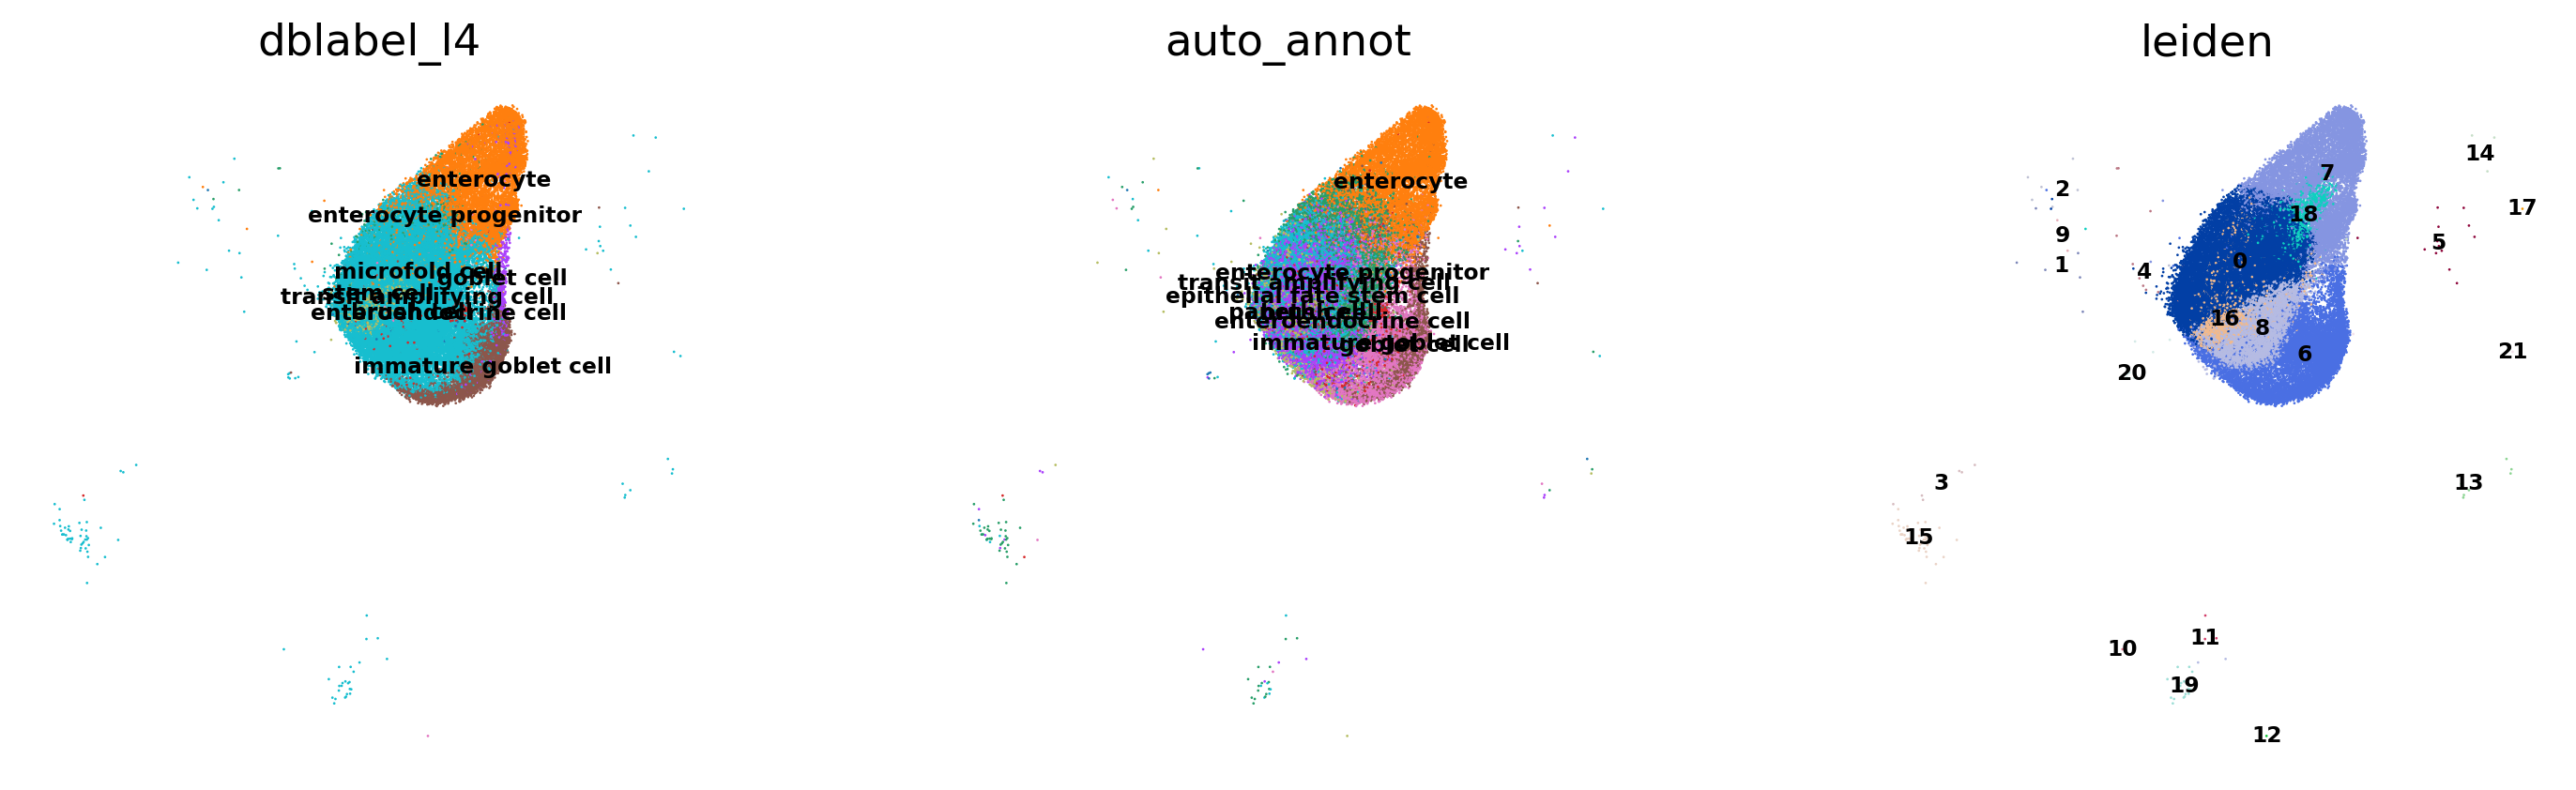

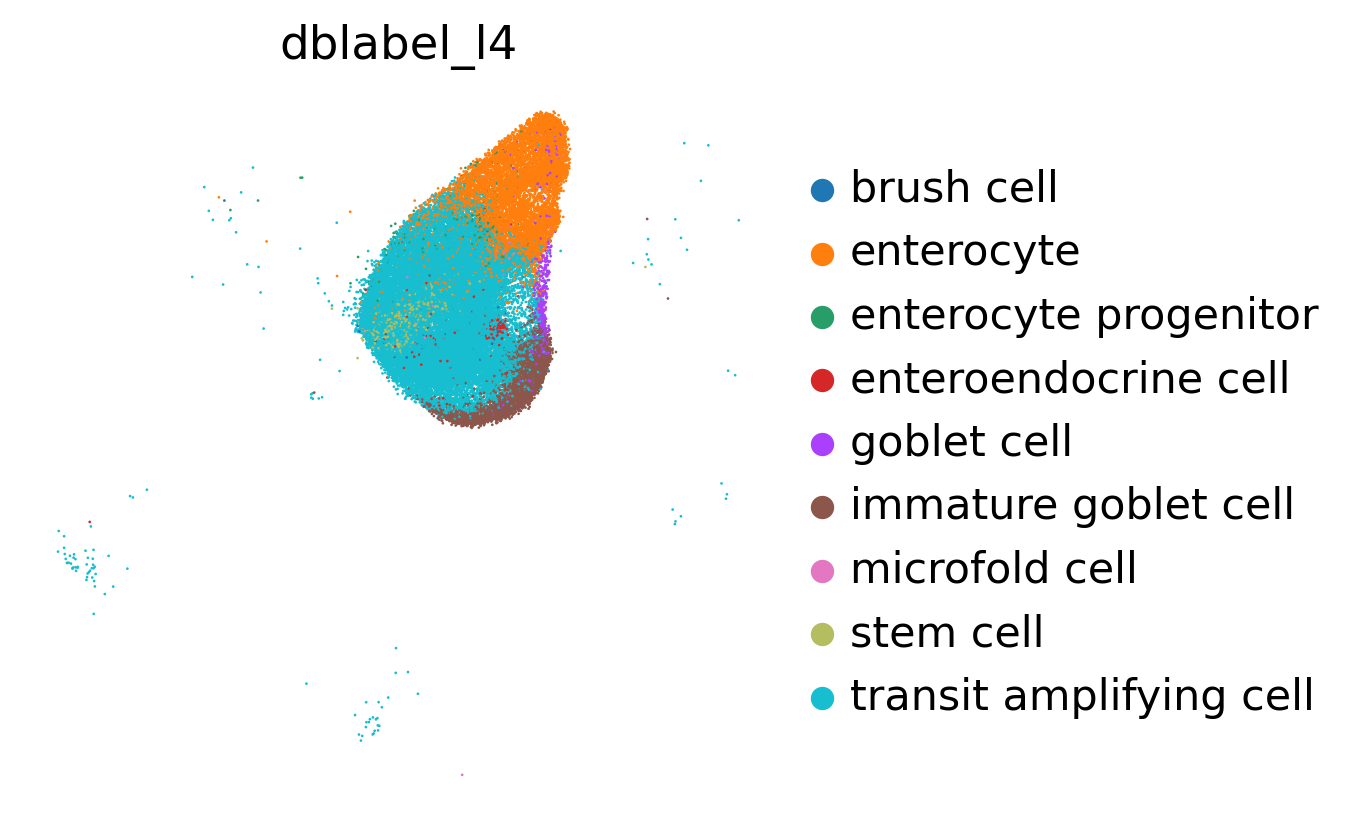

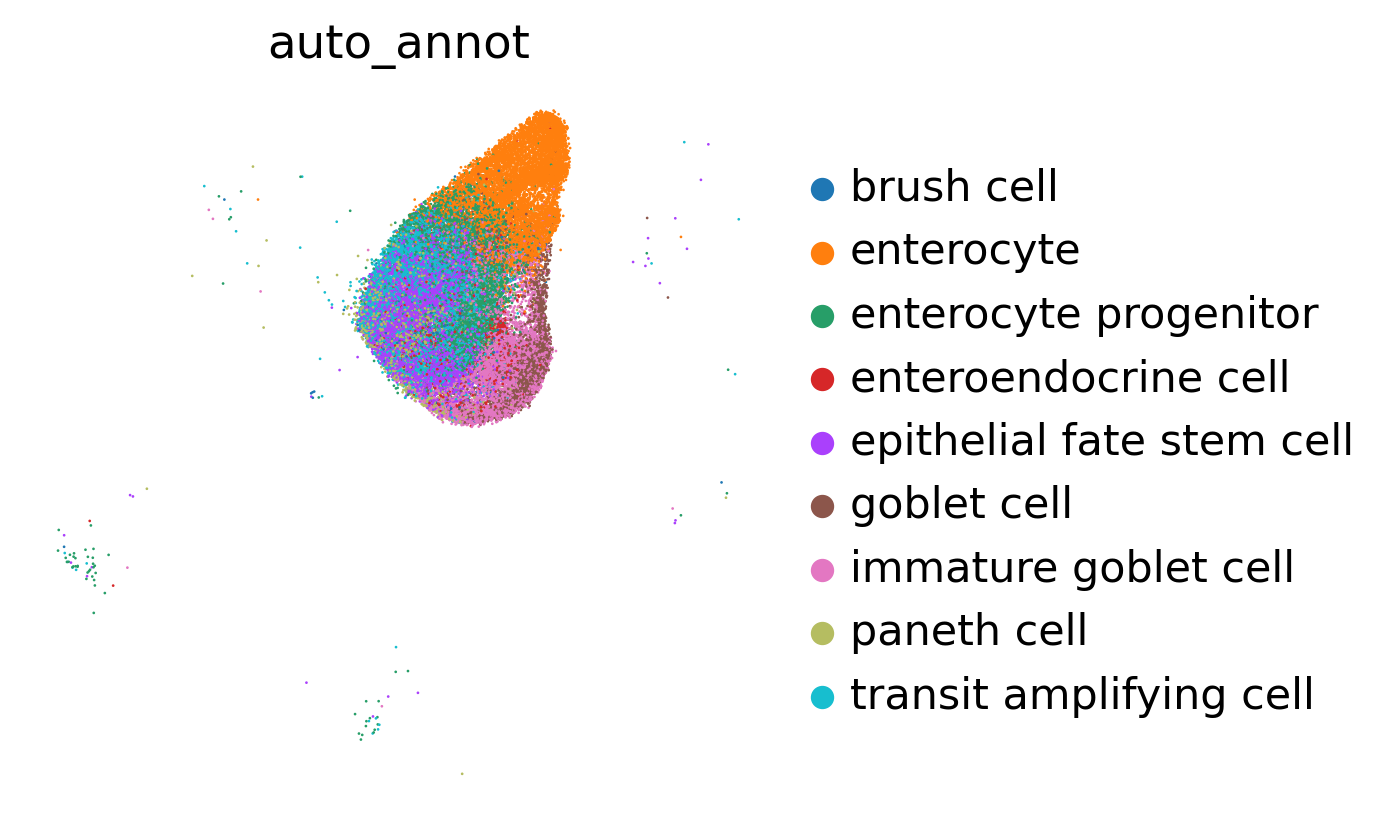

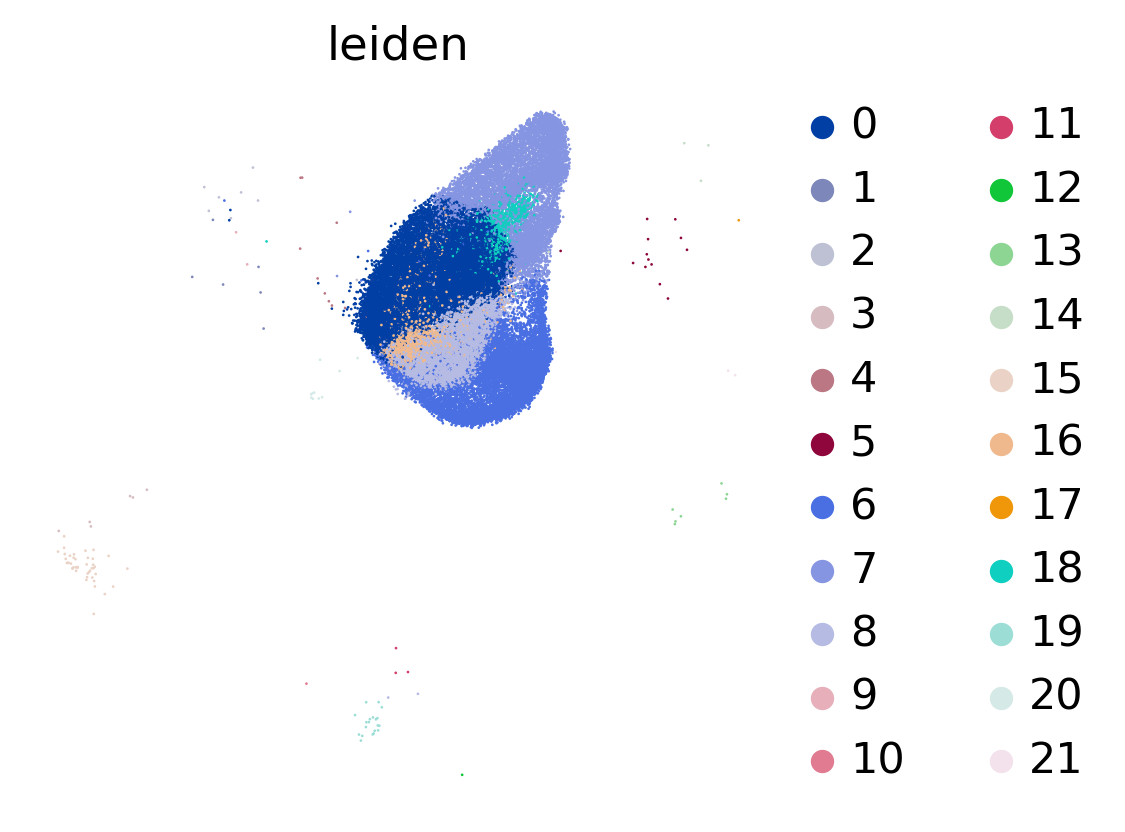

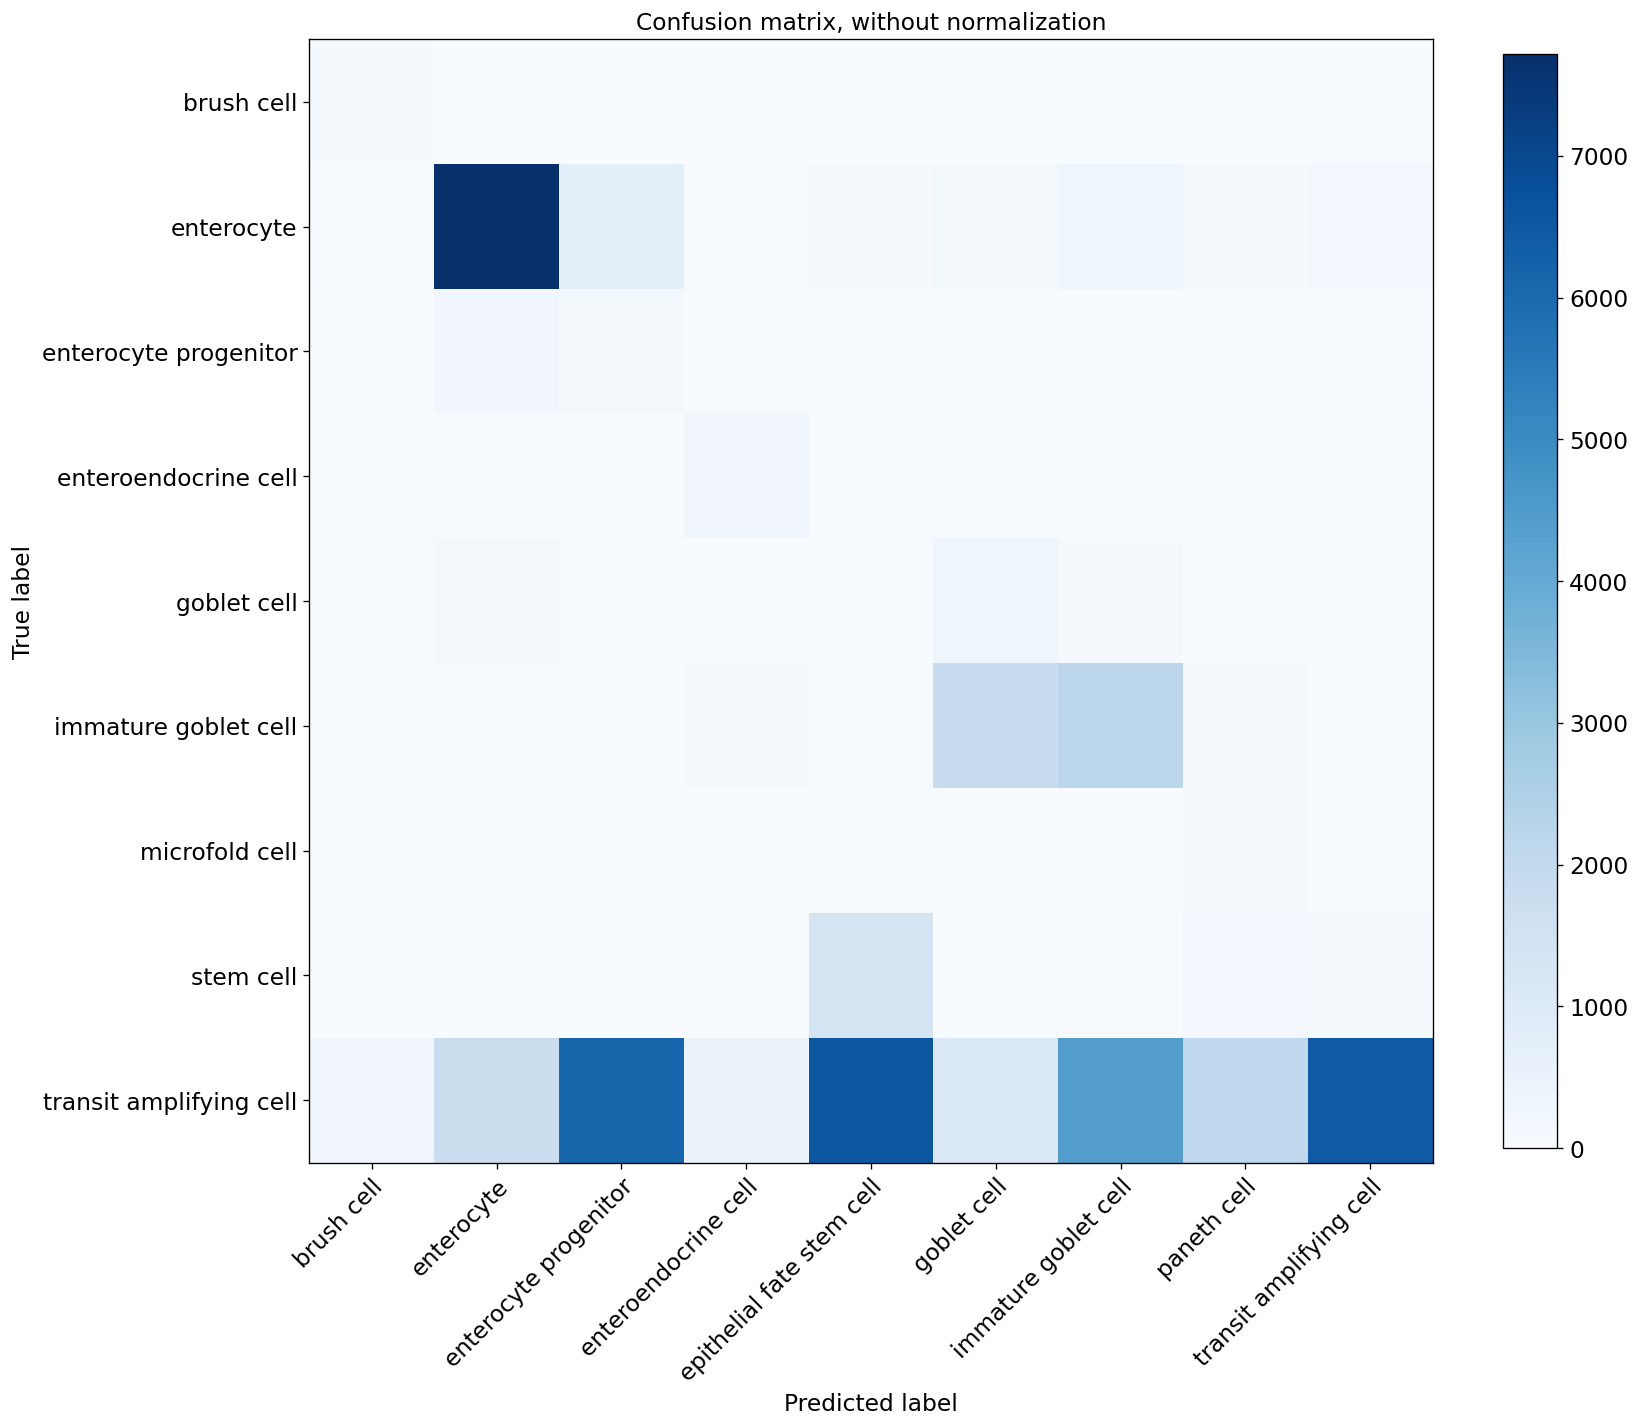

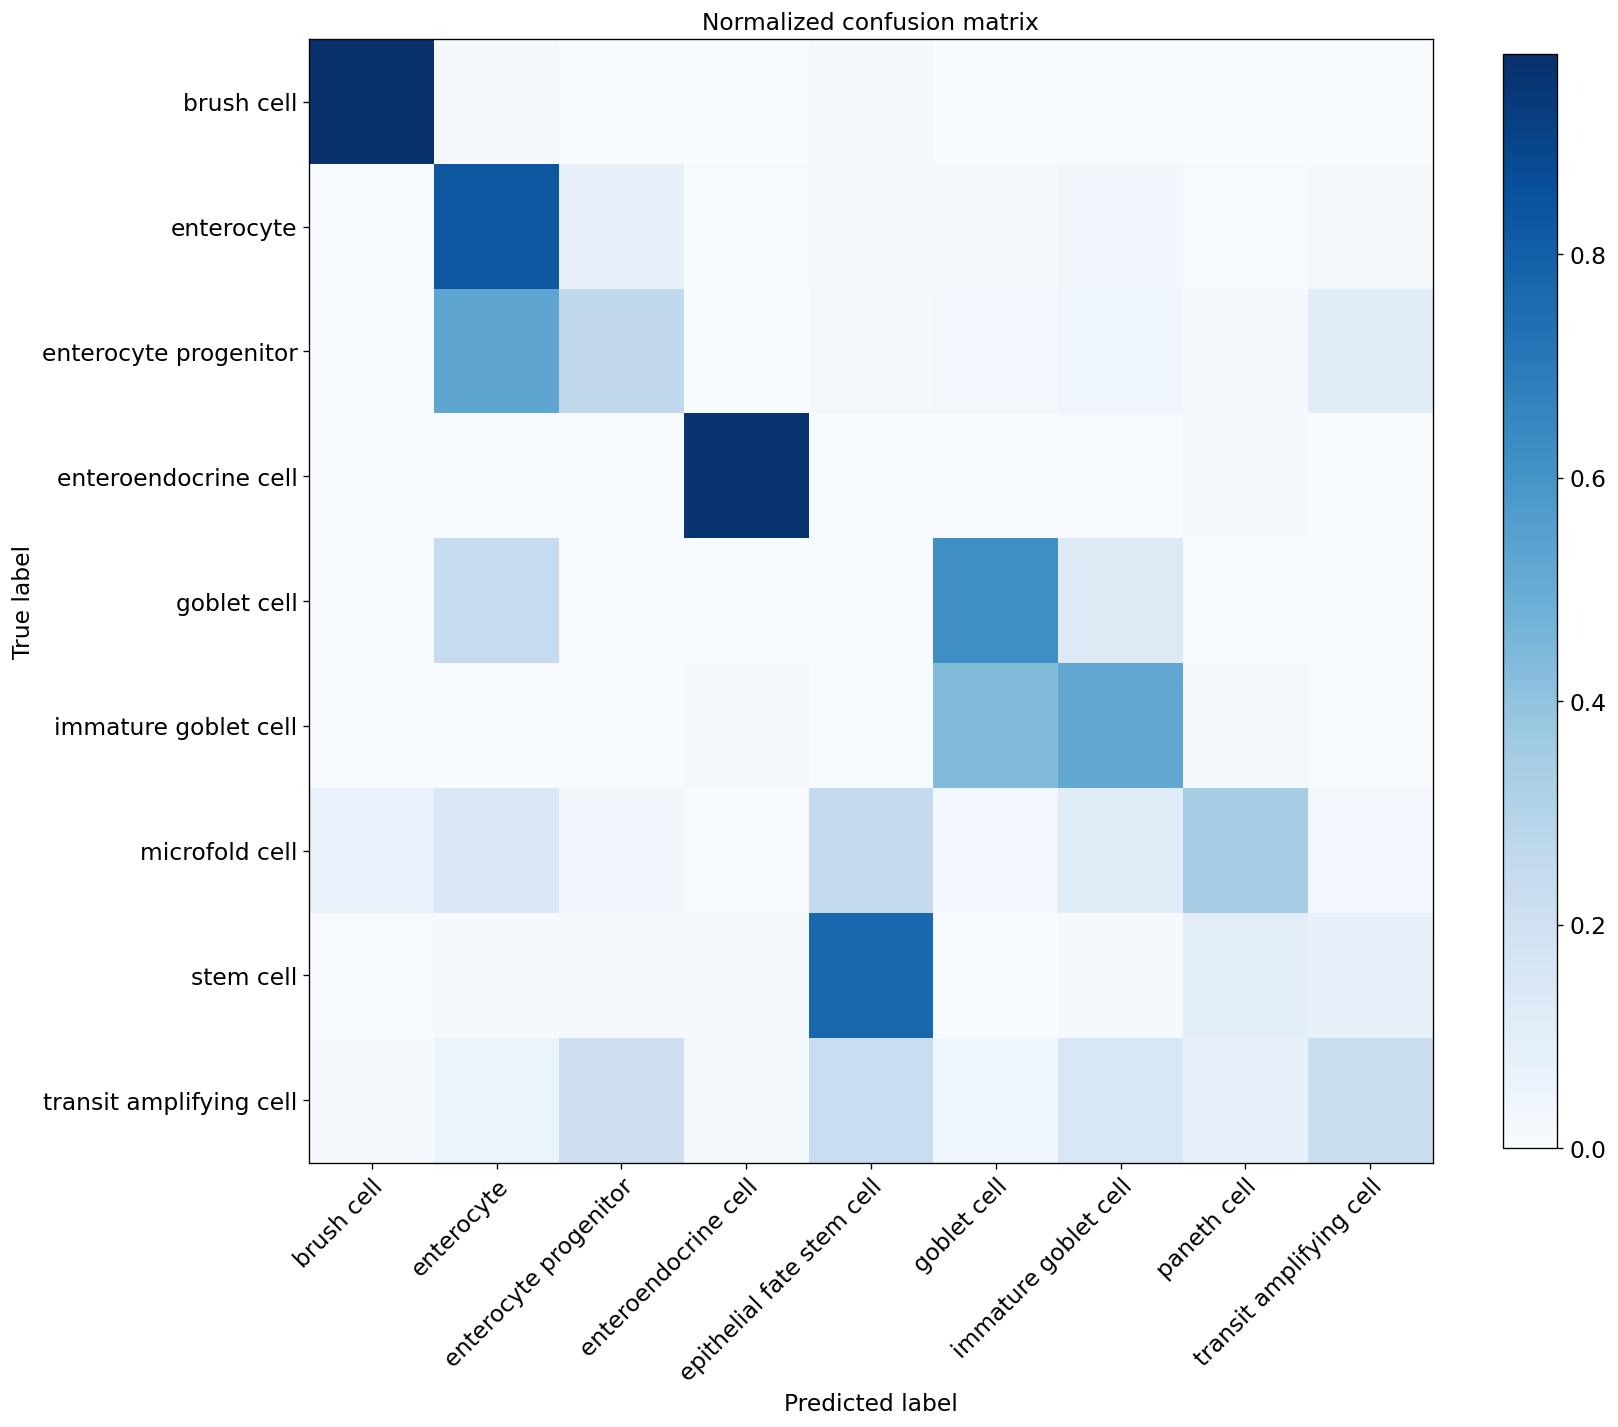

In [22]:
%matplotlib inline

bc.tl.report(
    adata_pred=adata_predicted,
    celltype=celltype_test, 
    method=method, 
    analysis_name=analysis_name,
    train_datasets = adata_trains,
    test_dataset = adata_orig,
    merge = merge,
    name_prediction='auto_annot', 
    name_report='auto_annot', 
    use_raw=use_raw,
    remove_nonshared=True, 
    clustering='leiden', 
    asymmetric_matrix=True, 
    delimiter='\t', 
    verbose=True
)

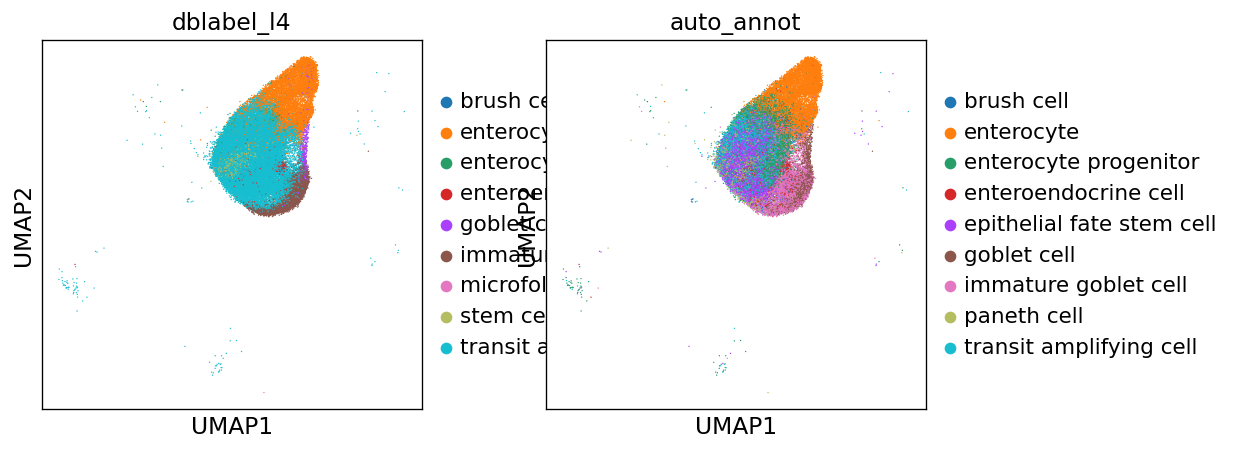

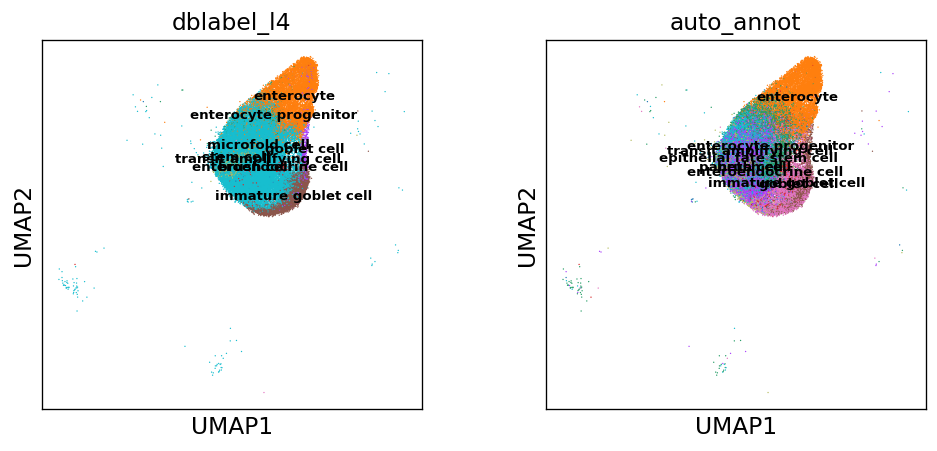

In [23]:
import scanpy as sc
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'])
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'], legend_loc='on data', legend_fontsize=8)

In [24]:
adata_train

View of AnnData object with n_obs × n_vars = 10896 × 270
    obs: 'CELL', 'CONDITION', 'sample_type', 'donor', 'region_x', 'sample', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'leiden', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'dblabel', 'barcode', 'region_y', 'cell_label', '_merge', 'dblabel_l4'
    var: 'SYMBOL', 'ENSEMBL-0', 'n_cells-0', 'total_counts-0', 'frac_reads-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'ENSEMBL-1', 'n_cells-1', 'total_counts-1', 'frac_reads-1', 'HGNC-1'
    uns: 'celltype0_colors', 'celltype1_colors', 'celltype2_colors', 'celltype3_colors', 'hvg', 'leiden', 'leiden_colors', 'rank_genes', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_scanorama'

In [25]:
adata_predicted_wo_unknown = adata_predicted.copy()
adata_predicted_wo_unknown = bc.subset_adata(adata_predicted_wo_unknown, adata_predicted_wo_unknown.obs.auto_annot != 'unknown', raw=False)
bc.pl.riverplot_2categories(adata_predicted_wo_unknown, [celltype_test, 'auto_annot'])

acc: 0.45
f1: 0.45
ami: -0.0
ari: -0.0
silhouette dblabel_l4: -0.11
silhouette random_labeling: -0.03
pair confusion matrix:
           0          1
0  638659546  528025888
1  528025888  430636980


... storing 'random_labeling' as categorical


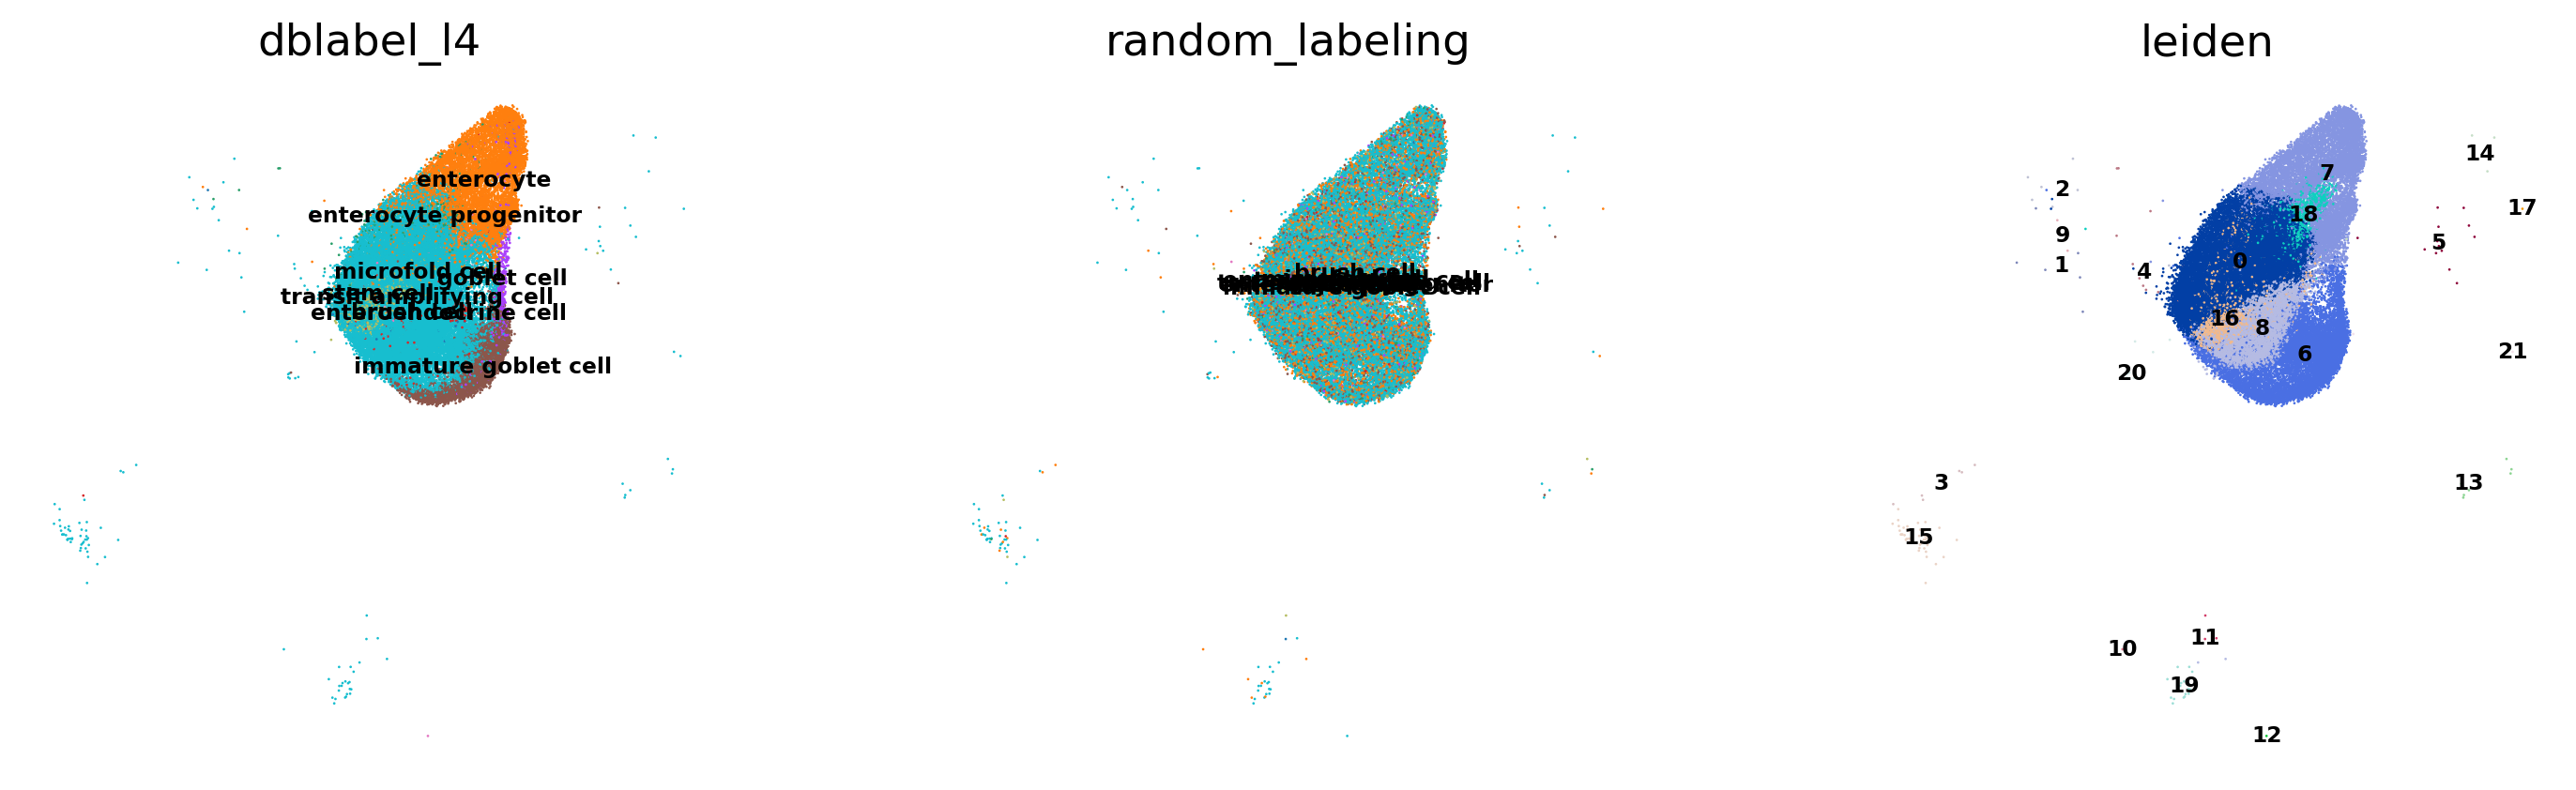

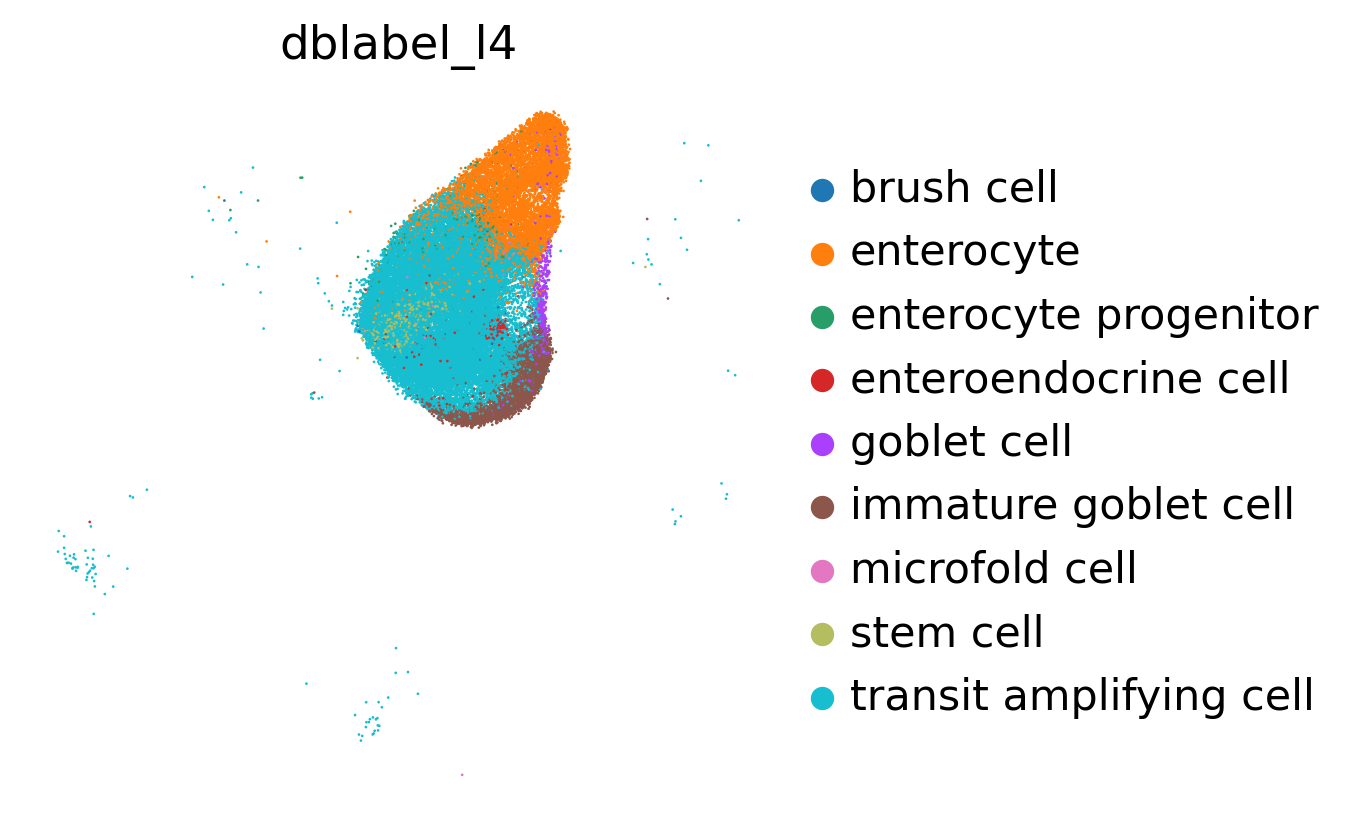

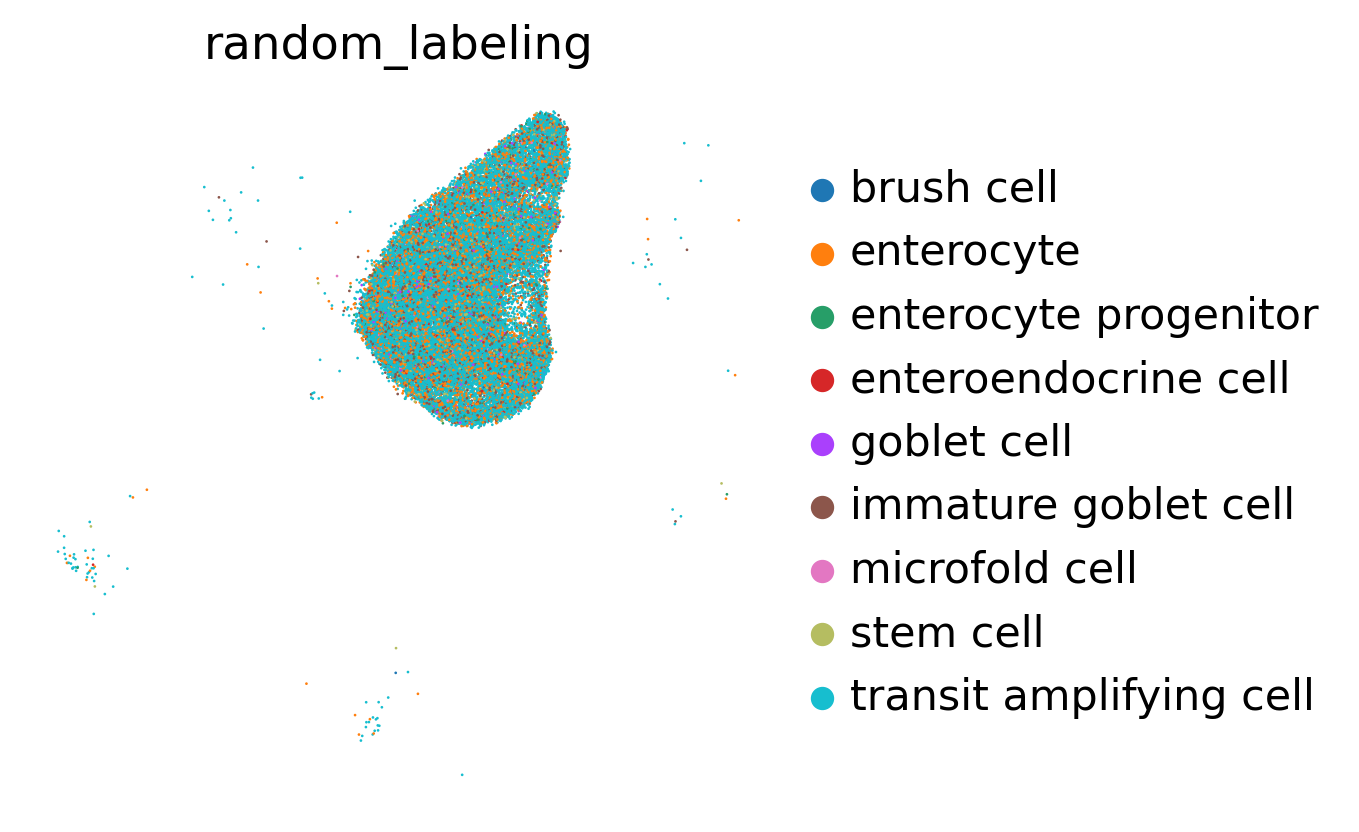

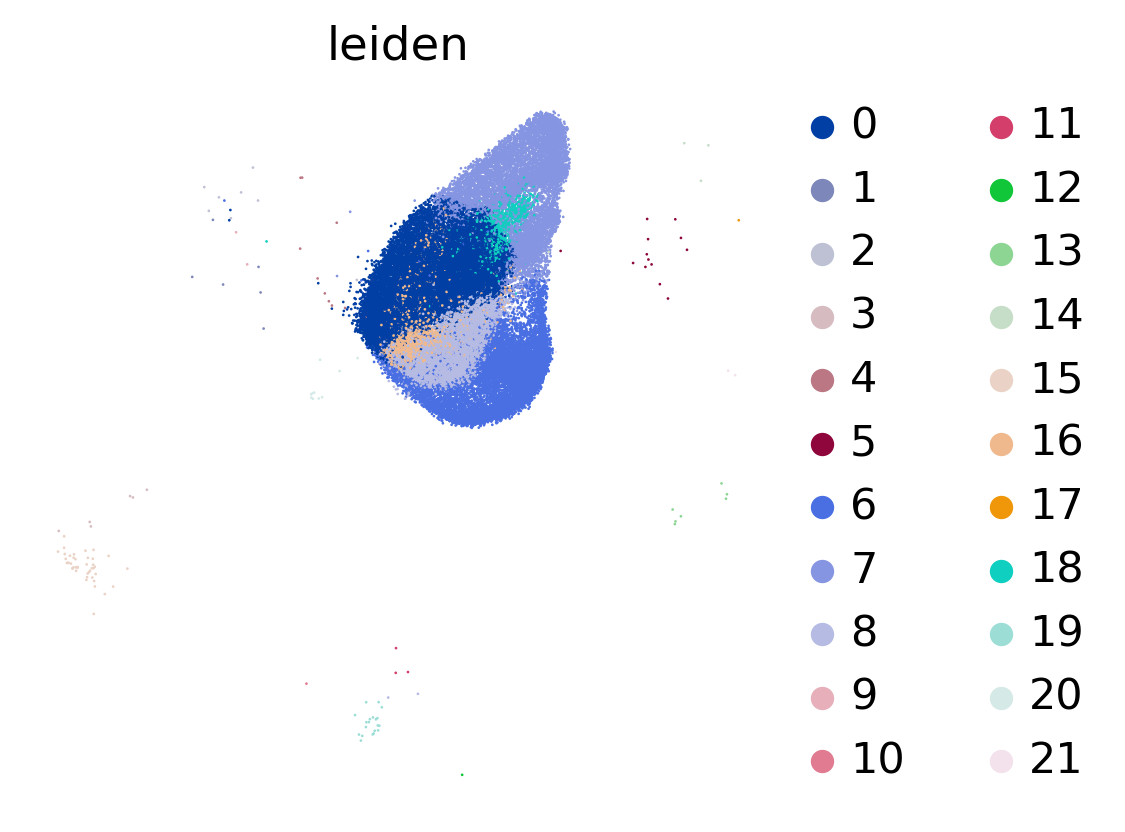

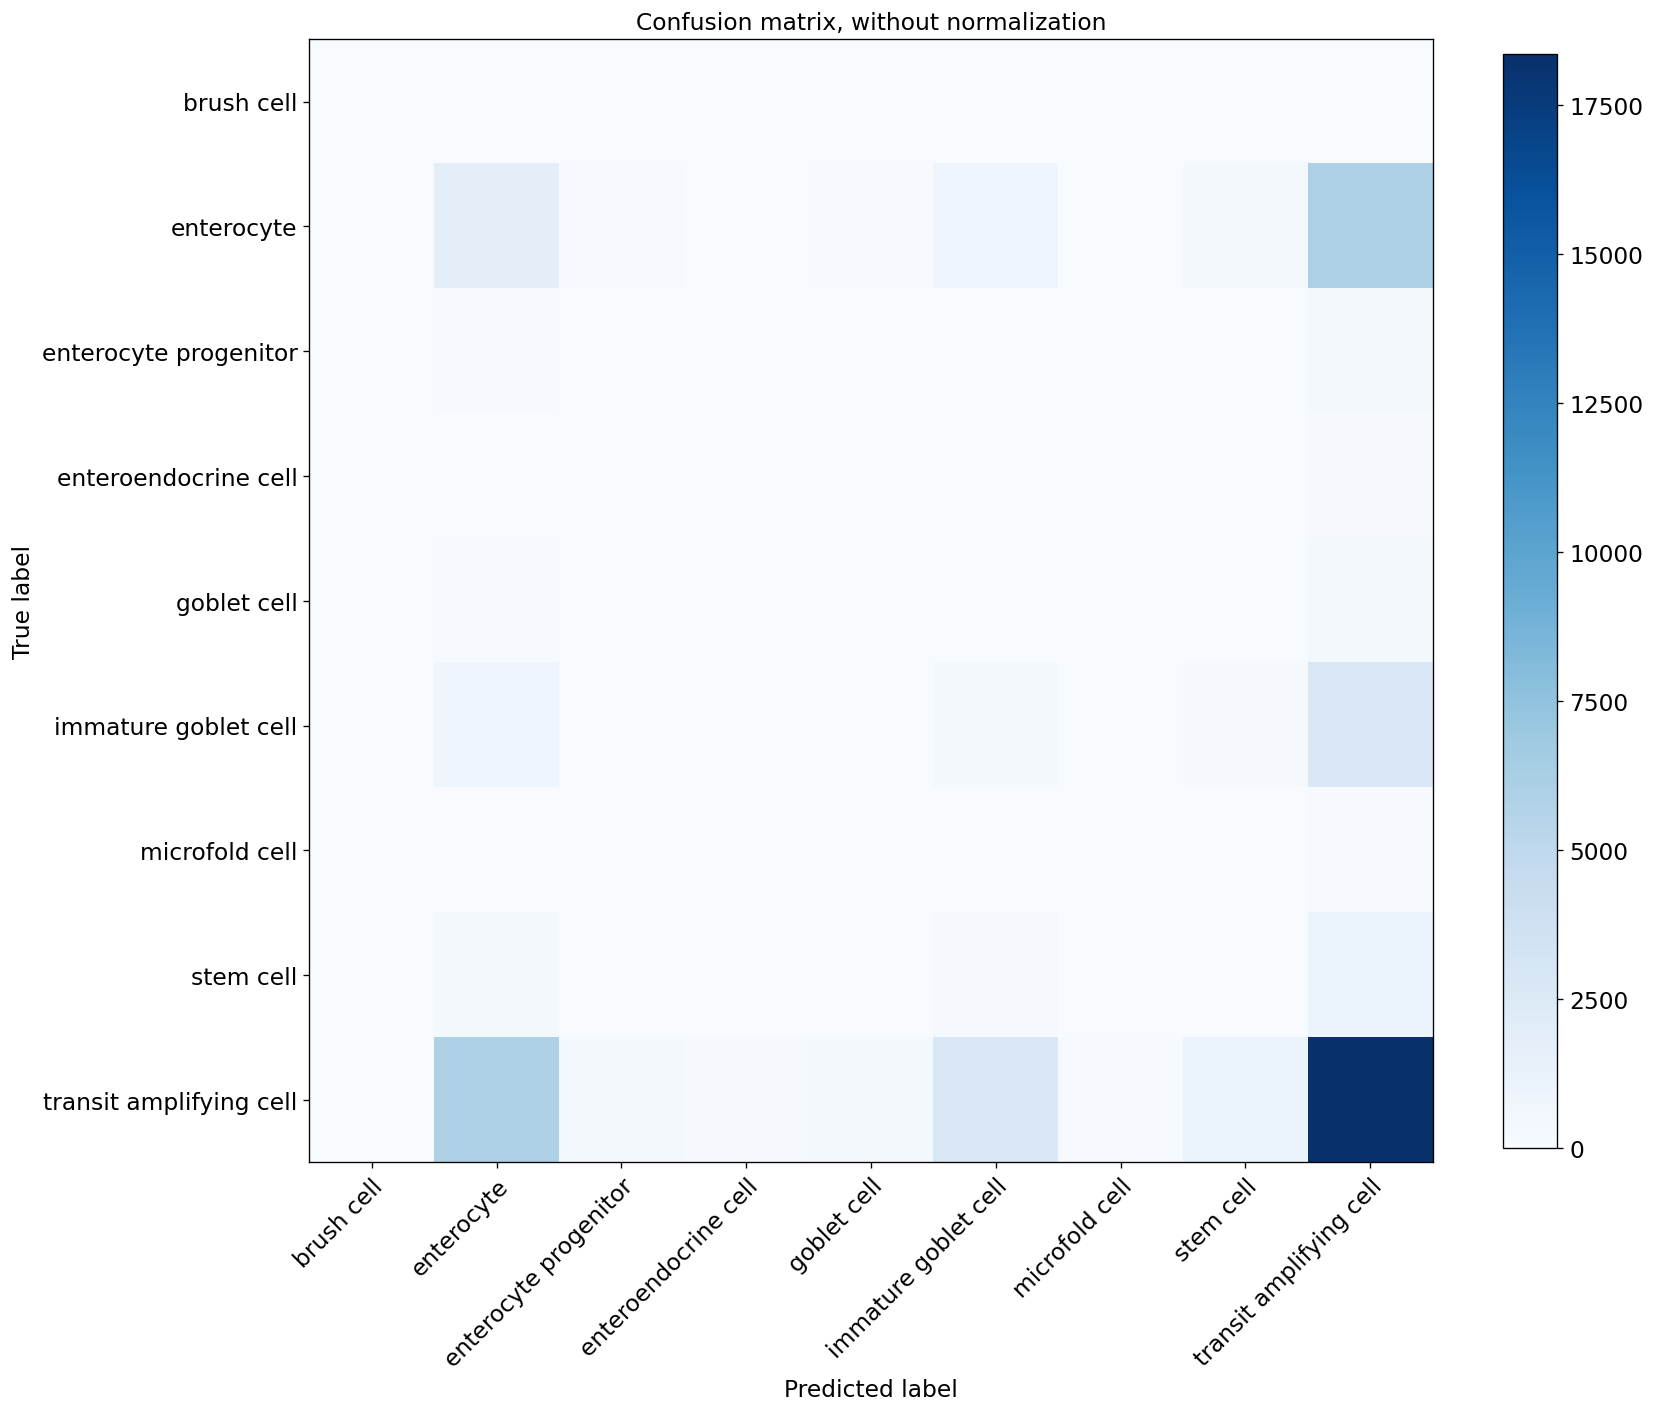

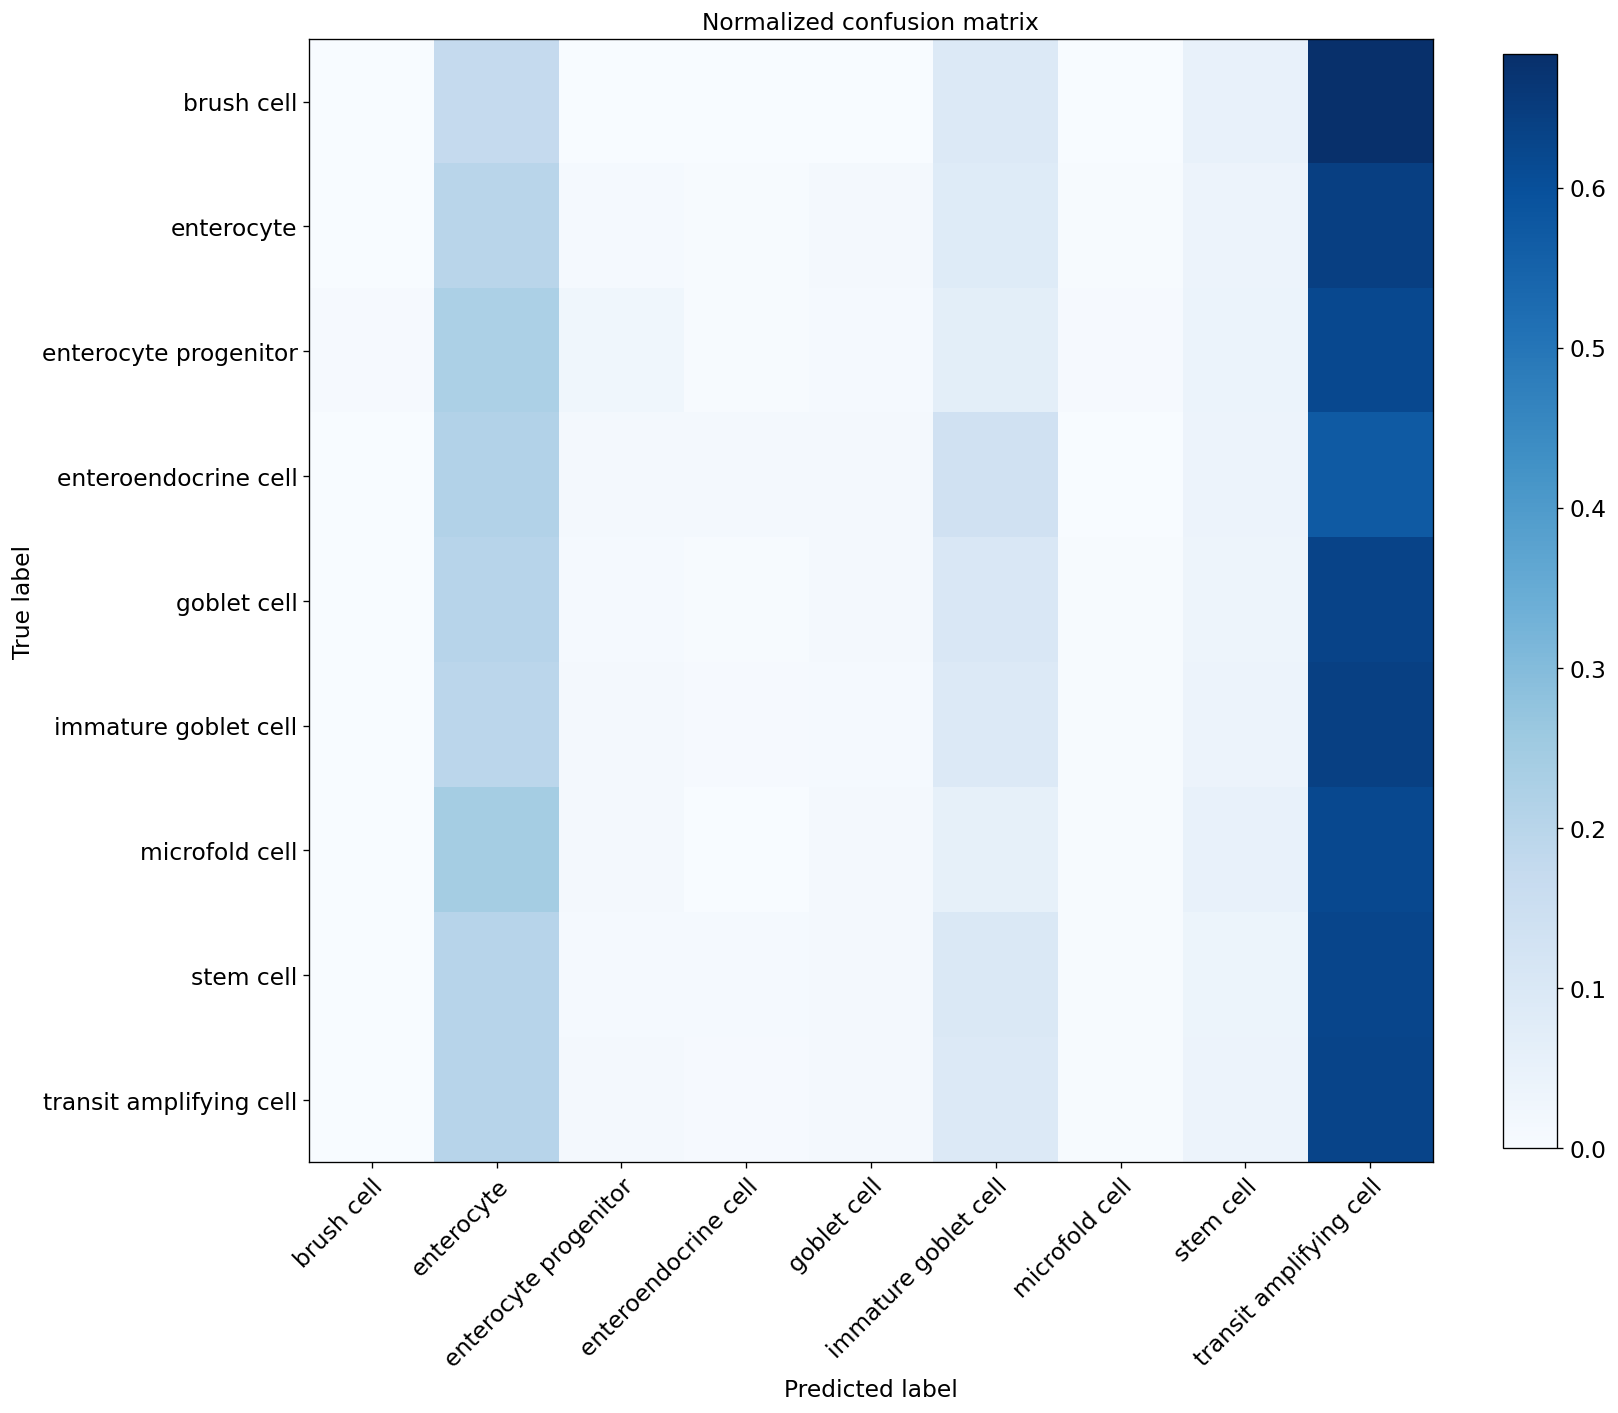

In [26]:
# Compare to random assignment
import random
random.seed(1)
adata_predicted.obs['random_labeling'] = list(adata_predicted.obs[celltype_test].sample(frac=1))

bc.tl.report(
    adata_pred=adata_predicted,
    celltype=celltype_test, 
    method="compare_to_random_" + method, 
    analysis_name=analysis_name,
    train_datasets = adata_trains,
    test_dataset = adata_orig,
    merge = merge,
    name_prediction="random_labeling",
    name_report="compare_to_random_auto_annot", 
    use_raw=use_raw,
    remove_nonshared=False, 
    clustering='leiden', 
    asymmetric_matrix=True, 
    delimiter='\t', 
    verbose=True)

In [27]:
from sinfo import sinfo
sinfo()

-----
anndata             0.7.5
besca               2.4+57.g5ad53b2
pandas              1.2.2
pkg_resources       NA
plotly              4.14.3
scanpy              1.6.1
sinfo               0.3.1
sklearn             0.24.1
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) [GCC 9.3.0]
Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-centos-7.4.1708-Core
24 logical CPU cores, x86_64
-----
Session information updated at 2021-07-18 09:25


### Convert to html

In [33]:
%%javascript

IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [34]:
nb_name = os.path.join(os.getcwd(), nb_name)

In [35]:
! jupyter nbconvert --to html {nb_name}

[NbConvertApp] Converting notebook /pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/intestine/auto_annot/auto_annot_Smillie2019_with_Haber2017_dblabel_l4.ipynb to html
[NbConvertApp] Writing 7082915 bytes to /pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/intestine/auto_annot/auto_annot_Smillie2019_with_Haber2017_dblabel_l4.html
